In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#We are going to generate flatmaps using the Flatmap class
# Q: where do I get the flatmaps module?
#https://github.com/LSSTDESC/NaMaster/blob/master/sandbox_validation/data/flatmaps.py -SAU
# Nord: I ran the conda install procedure, but flatmaps still does not imprt. 
import flatmaps as fm
from astropy.wcs import WCS

# To generate maps in flat-sky approximation we need NaMaster (pymaster)
# To install pymaster -> conda install namaster -c conda-forge

In [2]:
# Q: where did this file come from?
# From CAMB (well from Kimmy, who generated it with CAMB), https://camb.info/readme.html -SAU

# Nord: where can I get this file so I can run this code?

# Q: what are each of the outputs?
#l modes, TT spectrum, EE spectrum, TE spectrum, Phi-Phi spectrup, Phi-T spectrum -SAU

# Q: What is "P?"
#Phi? -SAU
# Nord: why are you unsure about this?

l, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)

In [3]:
# Generate an artificial power-spectrum (you can use a "realistic" power-spectrum from CAMB or CLASS)
# ells_input = np.arange(1,10000) # We generate 10,000 multipoles
clTT = clTTa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clEE = clEEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clTE = clTEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clPP = clPPa / (l**4 * (2.726 * 1e6)**2) # Simple power-law power-spectrum, @vis: creates the 1D spectrum to draw from
clPT = clPTa / (l**4) # Simple power-law power-spectrum
cl_input = [clTT, clEE, clTE, clPP, clPT]

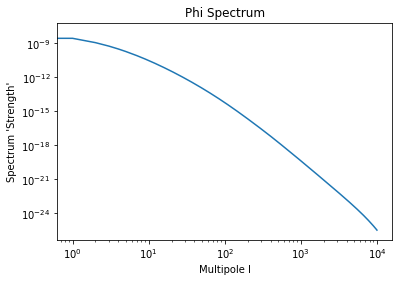

In [4]:
# Q: what are the units on these axes? 
#X-axis is l, Y-axis I don't think has units?
#Because CAMB says the units are microK^2, and then we divide out by microK^2 when normalizing

# Nord: Please label the y and x axes
plt.plot(clPP)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("Spectrum 'Strength'") #SAU: We have not confirmed the units on this
plt.xscale("log")
plt.yscale("log")

In [5]:
# Create the empty map object with the resolution that we want
# Set parameters for empy map with resolution
# Q: there is reso with pixels, but then side defined separately. These seem to be redundant definitions that could lead to a logical conflict.
# I agree with this statement. I was following convention used in the notebook I inherited.
# Nord: please change convention so that we don't get confused later on.
pixels = 192.
side = 5 #5 degrees
reso = side/pixels 

# Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = pixels #Number of pixels in the x axis
ny = pixels #Number of pixels in the y axis
# Q: should this be equal to pixels?
# SAU: yes

# 
w.wcs.crpix = [nx/2, ny/2] # Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] # Center coordinates RA, DEC at 0,0
# Comment: The thing below should probably be an input in the previous cell so we can keep better track of it.
# Comment: we don't want this defined twice. it will be confusing, especially in a notebook.
#SAU: Ok, deleted
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] # Airy projection



In [6]:
# This is the map object that will be used to generate the fake CMB maps
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) 

In [10]:
# Q: What is the math related to this?
#SAU: I don't know, I can look into it though
phi_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = 0)

TypeError: 'float' object cannot be interpreted as an index

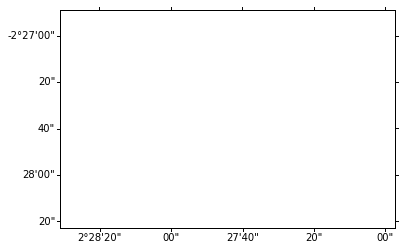

In [16]:
fmi.view_map(phi_map[0].flatten()) 

In [ ]:
phi_map_fft = np.fft.fft2(phi_map[0])

plt.imshow(abs(phi_map_fft), norm=matplotlib.colors.LogNorm())

np.save("phi_map_fft", phi_map_fft)

In [ ]:
# Q: What is the difference between this data and the data in the previous cell?
#SAU: This is the data after it's been loaded into the QuickLens structure.
#This was in order to debug to figure out why the phi map looked stronger after going into the quicklens data structure
#Apparently when the phi map is loaded into the QuickLens data structure, it gets multiplied by a scale factor
#I couldn't find any documentation explaining why.
phi_map_ql = np.load("phi_map_ql_structure.npy")

In [ ]:
data = phi_map_ql/phi_map[0]

In [ ]:
#Nord: Please label x and y axes, and the colorbar scale.
plt.imshow(1/data)
plt.colorbar()

In [ ]:
phi_map_fft_ql = np.load("phi_map_fft_ql_structure.npy")

In [ ]:
plt.imshow(abs(phi_map_fft_ql)-abs(phi_map_fft), norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [ ]:
phi_map_ql

In [ ]:
num_maps = 11200
i=0
all_maps = np.zeros([num_maps,int(pixels),int(pixels)])
while i < num_maps:
    map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = i)
    all_maps[i] = map_gen
    if np.mod(i,100) == 0:
        print i,
    i+=1

In [ ]:
fmi.view_map(all_maps[502].flatten())

In [ ]:
np.save("./all_phi_map_fft", all_maps)

In [ ]:
np.shape(all_maps)